In [153]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 

import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Statistics 

  Activating environment at `C:\Users\alect\OneDrive\Documents\CMU MRSD\Spring 2023\OCRL\OCRL-Project\Project.toml`


In [154]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","planar_quadrotor.jl"))

check_dynamic_feasibility (generic function with 1 method)

In [197]:
function diff_drive_dynamics(params, x,u)
    
    Vx = u[1]
    ω = u[2]
    
    θ = x[3]
    
    ẋ = [Vx * cos(θ),
        Vx * sin(θ),
        ω]
    
    return ẋ
end


diff_drive_dynamics (generic function with 1 method)

In [198]:
function skid_steering_dynamics(params, x,u)
    return 1
end

skid_steering_dynamics (generic function with 1 method)

In [199]:
""" We use the discretized version of the dynamics to create a dynamics constraint  """

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real, dynamics::Function)::Vector 
    
    x_half = ( (1 / 2) * (x1 + x2) ) + ( (dt / 8 ) * ( dynamics(params, x1, u) - dynamics(params, x2, u) ) )
    
    ẋ1 = dynamics(params, x1, u)
    ẋ2 = dynamics(params, x2, u)
    ẋ_half = dynamics(params, x_half, u)
    
    resid = x1 + ( (dt/6) * (ẋ1 + ( 4 * ẋ_half ) + ẋ2)) - x2

    return resid

end

hermite_simpson (generic function with 1 method)

In [200]:
""" Use the stacked dynamics to create the dynamics constraints """

function mobile_base_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
        
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        
        xi1p = Z[idx.x[i+1]]
        
        # discretized dynamics
        c[idx.c[i]] = hermite_simpson(params, xi, xi1p, ui, dt, diff_drive_dynamics)
    end
    return c 
end

mobile_base_dynamics_constraints (generic function with 1 method)

In [201]:
function mobile_base_cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N
    xg = params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    J = 0 
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        # stage cost
        J += 0.5 * transpose(xi - xg) * Q * (xi - xg) + 0.5 * transpose(ui) * R * ui
    end
    
    # terminal cost 
    xn = Z[idx.x[N]]
    J += 0.5 * transpose(xn - xg) * Qf * (xn - xg) 
    
    return J 
end

quadrotor_cost (generic function with 1 method)

In [202]:
function quadrotor_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx = params.N, params.idx
    xic = params.xic
    xg = params.xg
        
    # initial condition constraints
    ic_ceq = Z[idx.x[1]] - xic
    
    # goal condition constraints
    goal_ceq = Z[idx.x[N]] - params.xg
    
    # dynamics constraint
    dyn_ceq = mobile_base_dynamics_constraints(params, Z)
    
    # stack them all
    c_eq = [ic_ceq; goal_ceq; dyn_ceq]
    
    return c_eq
end

quadrotor_equality_constraint (generic function with 1 method)

In [238]:
function ineq_constraint(params, Z)
    
    idx, N = params.idx, params.N
    pos_obs1, pos_obs2, pos_obs3 = params.pos_obs1, params.pos_obs2, params.pos_obs3
        
    # collision constraints
    pos_obs1 = [params.pos_obs1 for i = 1:N]
    pos_obs2 = [params.pos_obs2 for i = 1:N]
    pos_obs3 = [params.pos_obs3 for i = 1:N]

    quad_pos = [Z[idx.x[i]][1:2] for i = 1:N]

    c_obs1 = norm.(quad_pos .- pos_obs1).^2
    c_obs2 = norm.(quad_pos .- pos_obs2).^2
    c_obs3 = norm.(quad_pos .- pos_obs3).^2
        
    c_ineq = [c_obs1; c_obs2; c_obs3]
    
    return c_ineq
end

ineq_constraint (generic function with 1 method)

In [241]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

"""
    quadrotor_reorient

Function for returning collision free trajectories for 3 quadrotors. 

Outputs:
    x1::Vector{Vector}  # state trajectory for quad 1 
    x2::Vector{Vector}  # state trajectory for quad 2 
    x3::Vector{Vector}  # state trajectory for quad 3 
    u1::Vector{Vector}  # control trajectory for quad 1 
    u2::Vector{Vector}  # control trajectory for quad 2 
    u3::Vector{Vector}  # control trajectory for quad 3 
    t_vec::Vector
    params::NamedTuple

The resulting trajectories should have dt=0.2, tf = 5.0, N = 26
where all the x's are length 26, and the u's are length 25. 

Each trajectory for quad k should start at `xkic`, and should finish near 
`xkg`. The distances between each quad should be greater than 0.8 meters at 
every knot point in the trajectory. 
"""
function quadrotor_reorient(;verbose=true)
    
    # problem size 
    nx = 3
    nu = 2
    dt = 0.2
    tf = 5.0
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    @show N
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial conditions and goal states 
    xic = [2.,25.,0.] # ic
    xg = [75., 25., 0.] # goal
    
    # LQR cost 
    Q = [1 0 0;
        0 1 0;
        0 0 10]
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
                
    pos_obs1 = [15., 30.]
    rad_obs1 = 4.
    
    pos_obs2 = [35., 24.]
    rad_obs2 = 10.
    
    pos_obs3 = [55., 35.]
    rad_obs3 = 8.
    
    rads = [rad_obs1; rad_obs2; rad_obs3]
    
    # load all useful things into params
    params = (xic=xic,
              xg = xg,
              dt = dt,
              N = N,
              idx = idx,
              Q = Q,
              R = R,
              Qf = Qf,
              pos_obs1 = pos_obs1,
              pos_obs2 = pos_obs2,
              pos_obs3 = pos_obs3,
              rads = rads,
              Vx_max = 1., # husky specs
              u_max = 25., # derived angular velocity
              num_obs = 3,
              avoid_dist = 6.,
              mass = 1.0, # quadrotor mass 
              g = 9.81,   # gravity 
              ℓ = 0.3,    # quadrotor length 
              J = .018)   # quadrotor moment of inertia 
            
    # warm start
    ref = range(xic, xg, length=N)
    
    z0 = 0.001*randn(idx.nz)
    for i=1:N

        x = ref[i][1]
        y = ref[i][2]
        
        z0[idx.x[i]] = [x, y,tan(y/x)]
    end
    
    x_l = -Inf * ones(idx.nz)
    x_u = Inf * ones(idx.nz)
    
    # bound the control outputs 
    for i = 1:N-1  
#         @show x_l[idx.u[i]]
        x_l[idx.u[i]] = [-params.Vx_max, -params.u_max]
            
        x_u[idx.u[i]] = [params.Vx_max, params.u_max]
    end
    
#     for i = 1:idx.nz
#         @show x_l[i], x_u[i]
#     end
    
    # constraint bounds
    c_l = [(params.avoid_dist+rad_obs1)^2 * ones(N); 
           (params.avoid_dist+rad_obs2)^2 * ones(N); 
           (params.avoid_dist+rad_obs3)^2 * ones(N)]

    c_u = Inf*ones(3*N)
    
    for i = 1:3*N
        @show c_l[i], c_u[i]
    end
    
#     @show size(c_l), size(c_u)
#     c_u = Inf*ones(3*N) #; 9*ones(N-1); ones(N)]
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 

    Z = fmincon(quadrotor_cost,quadrotor_equality_constraint, ineq_constraint,x_l,x_u,c_l,c_u,z0,
    params, diff_type; tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # return the trajectories 
    
    x = [ Z[idx.x[i]] for i = 1:N]          
    u = [ Z[idx.u[i]] for i = 1:(N-1)]
                            
    return x, u, t_vec, params 
end
    
    

quadrotor_reorient

N = 26
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (100.0, Inf)
(c_l[i], c_u[i]) = (256.0, Inf)
(c_l[i], c_u[i]) = (256.0, Inf)
(c_l[i], c_u[i]) = (256.0, Inf)
(c_l[i], c_u[i]) = (256.0, Inf)
(c_l[i], c_u[i]) = (256.0, Inf)
(

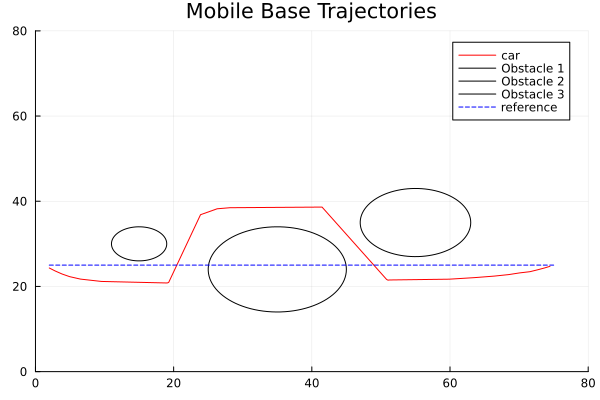

Test Summary:      | Pass  Total
quadrotor reorient |    5      5

Test.DefaultTestSet("quadrotor reorient", Any[], 5, false, false)

In [242]:
@testset "quadrotor reorient" begin
    
    x, u, t_vec, params  = quadrotor_reorient(verbose=false)
    
#     #---------------testing-----------------
   # check lengths of everything 
    @test length(x) == params.N
    @test length(u) == params.N - 1
    
    # check for collisions 
    distances = [zeros(3) for i = 1:params.N]
    for i = 1:params.N   
        distances[i][1] = norm(x[i][1:2] - params.pos_obs1, 2)
        distances[i][2] = norm(x[i][1:2] - params.pos_obs2, 2)
        distances[i][3] = norm(x[i][1:2] - params.pos_obs3, 2)    
    end
    
    @test minimum(minimum.(distances[1])) >= params.rads[1]
    @test minimum(minimum.(distances[2])) >= params.rads[2]
    @test minimum(minimum.(distances[3])) >= params.rads[3]
    
    
    
#     #---------------plotting/animation-------
    
    # regenerate the ref for plotting    
    ref = range(params.xic, params.xg, length=params.N)
    refx = [ref[i][1] for i = 1:params.N]
    refy = [ref[i][2] for i = 1:params.N]
    
    # pull out the pos from the state
    carx = [x[i][1] for i = 1:params.N]
    cary = [x[i][2] for i = 1:params.N]
    
    # display the actual states and controls
    for i = 1:params.N-1
        @show x[i]
        @show u[i]
    end
    @show x[params.N]
    
    # Show the plot
    plot(carx, cary, color = :red,title = "Mobile Base Trajectories", label = "car")
    
    # Create three circles for obs
    obs = [params.pos_obs1, params.pos_obs2, params.pos_obs3]
    for i = 1:params.num_obs  
        θ = range(0, stop=2π, length=100)
        x = obs[i][1] .+ params.rads[i]*cos.(θ)
        y = obs[i][2] .+ params.rads[i]*sin.(θ)

        plot!(x, y, color = :black, label="Obstacle $i")
#         fill(x, y, color=:blue, alpha=0.2)
    end
    
    xlims!((0, 80))
    ylims!((0, 80))
    display(plot!(refx, refy, color = :blue, linestyle= :dash, label = "reference "))
    
end